In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eq5d=pd.read_csv('../rq1/rq1_cleaned_no_ae.csv')


scores=pd.read_excel('../data/Scores 6 Jan 2025_Prescribed_Completed Baseline PROMs.xlsx')
gad7=scores[scores['promName']=='GAD7']
gad7=gad7[['SID','Round','promName','total_score','completionDate']]


gad7_wide = gad7.pivot_table(index='SID', 
                                    columns='Round', 
                                    values='total_score', 
                                    aggfunc='first')

gad7_wide.columns = [f"GAD7_Round{r}" for r in gad7_wide.columns]
gad7_wide = gad7_wide.reset_index()
gad7= pd.merge(eq5d, gad7_wide, on='SID', how='left')
gad7=gad7.rename(columns={'GAD7_Round1_y': 'GAD7_Round1',})

insomnia=scores[scores['promName']=='insomniaEfficacyMeasure']
insomnia=insomnia[['SID','Round','promName','total_score','completionDate']]


insomnia_wide = insomnia.pivot_table(index='SID', 
                                    columns='Round', 
                                    values='total_score', 
                                    aggfunc='first')

insomnia_wide.columns = [f"insomniaEfficacyMeasure_Round{r}" for r in insomnia_wide.columns]
insomnia_wide = insomnia_wide.reset_index()
insomnia_wide= pd.merge(gad7, insomnia_wide, on='SID', how='left')
insomnia=insomnia_wide.rename(columns={'insomniaEfficacyMeasure_Round1_y': 'insomniaEfficacyMeasure_Round1',})
full=insomnia.copy()


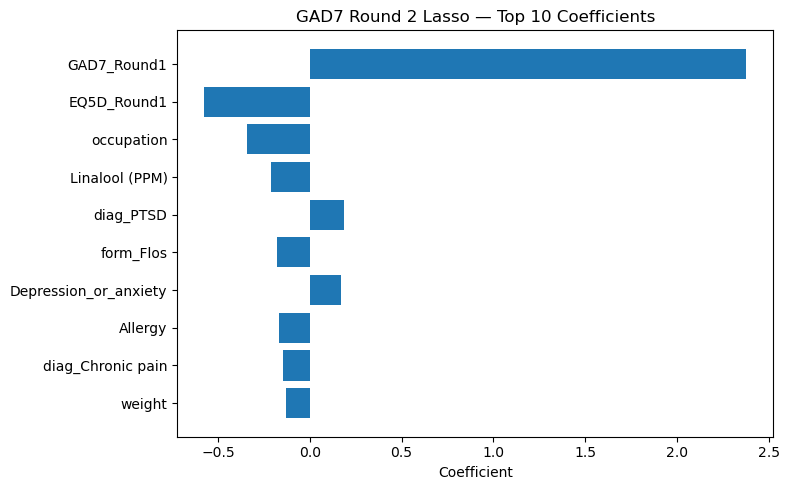

/rds/general/user/hsl121/home/anaconda3/envs/TDS/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


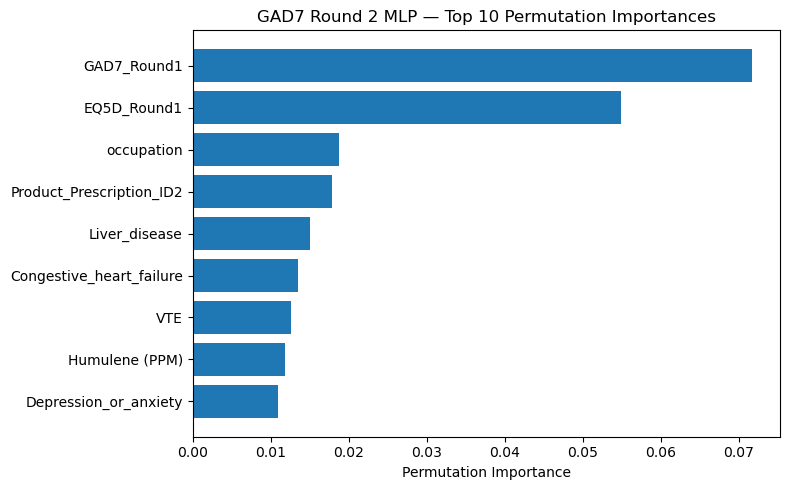

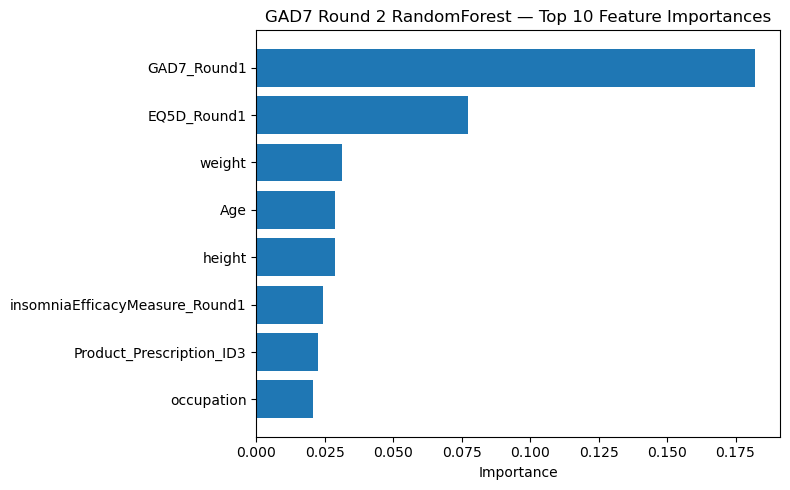

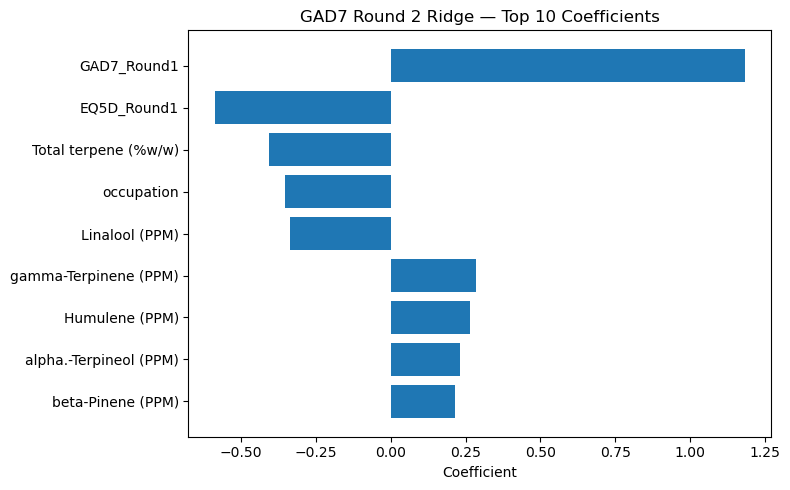

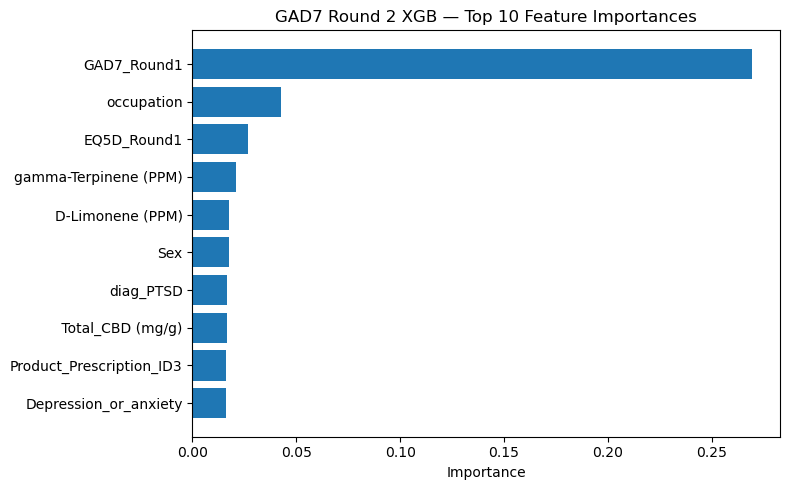

In [4]:
# Load saved models and plot top predictors
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 0) Rename any mis-named columns on full before building X
for old, new in [
    ('GAD7_Round1_y', 'GAD7_Round1'),
    ('insomniaEfficacyMeasure_Round1_y', 'insomniaEfficacyMeasure_Round1'),
    ('GAD7_Round1_x', 'GAD7_Round1'),
    ('insomniaEfficacyMeasure_Round1_x', 'insomniaEfficacyMeasure_Round1'),
]:
    if old in full.columns:
        full = full.rename(columns={old: new})

# 1) Prepare feature matrix X and target y
drop_cols = [
    'SID',
    *[f"GAD7_Round{r}" for r in range(2,14)],
    *[f"EQ5D_Round{r}" for r in range(2,7)],
    *[f"insomniaEfficacyMeasure_Round{r}" for r in range(2,14)],
]
X = full.drop(columns=drop_cols)
X = X.loc[:, ~X.columns.duplicated()]
feature_names = X.columns.tolist()
y = full['GAD7_Round2']

from sklearn.inspection import permutation_importance

models_dir = '/rds/general/user/hsl121/home/hda_project/final_pipeline/results/models'
for fname in sorted(os.listdir(models_dir)):
    if not (fname.endswith('.pkl') and fname.startswith('gad7_round2')):
        continue

    # 1) Nice title
    model_label = fname.replace('.pkl','')
    parts = model_label.split('_')
    parts[0] = parts[0].upper()
    parts[1] = parts[1].capitalize().replace('Round2','Round 2')
    nice_label = " ".join(parts)

    # 2) Load pipeline and grab expected features
    pipeline = joblib.load(os.path.join(models_dir, fname))
    # assume you did include a StandardScaler step; otherwise switch to model
    scaler = pipeline.named_steps.get('scaler', None)
    if scaler is not None:
        expected = scaler.feature_names_in_
    else:
        expected = pipeline.named_steps['model'].feature_names_in_

    model = pipeline.named_steps['model']

    # 3) Compute importances / coefs / permutation‐importances
    if hasattr(model, 'feature_importances_'):
        vals = model.feature_importances_
        df   = pd.DataFrame({
            'feature': expected,
            'importance': vals
        }).nlargest(10, 'importance')
        df['feature'] = df['feature'].str.replace(r'(_[xy])$', '', regex=True)
        title, x, xlabel = (
            f"{nice_label} — Top 10 Feature Importances",
            df['importance'],
            'Importance'
        )

    elif hasattr(model, 'coef_'):
        coefs = model.coef_.ravel()
        df    = pd.DataFrame({
            'feature': expected,
            'coef':    coefs
        })
        df['importance'] = df['coef'].abs()
        df    = df.nlargest(10, 'importance')
        df['feature'] = df['feature'].str.replace(r'(_[xy])$', '', regex=True)
        title, x, xlabel = (
            f"{nice_label} — Top 10 Coefficients",
            df['coef'],
            'Coefficient'
        )

    else:
        # permutation importance
        X_sample = X.sample(n=min(200, len(X)), random_state=42)
        y_sample = y.loc[X_sample.index]

        # align columns
        for feat in expected:
            if feat not in X_sample.columns:
                if feat.endswith('_y') or feat.endswith('_x'):
                    base = feat[:-2]
                else:
                    base = feat
                X_sample[feat] = X_sample[base]
        X_sample = X_sample[expected]

        r = permutation_importance(
            pipeline, X_sample, y_sample,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        df   = pd.DataFrame({'feature': expected, 'importance': r.importances_mean})

        df   = df.nlargest(10, 'importance')
        df['feature'] = df['feature'].str.replace(r'(_[xy])$', '', regex=True)
        title, x, xlabel = (
            f"{nice_label} — Top 10 Permutation Importances",
            df['importance'],
            'Permutation Importance'
        )

    # 4) Plot
    fig, ax = plt.subplots(figsize=(8,5))
    ax.barh(df['feature'][::-1], x[::-1])
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


In [17]:
X.columns.tolist()

['EQ5D_Round1',
 'Age',
 'Sex',
 'occupation',
 'weight',
 'height',
 'Myocardial_infarction',
 'Congestive_heart_failure',
 'Peripheral_vascular_disease',
 'Cerebrovascular_accident_or_transient_ischemic_attack',
 'Dementia',
 'Chronic_obstructive_pulmonary_disease',
 'Connective_tissue_disease',
 'Peptic_Ulcer_Disease',
 'Liver_disease',
 'Diabetes',
 'Hemiplegia',
 'Moderate_to_severe_chronic_kidney_disease',
 'Solid_tumour',
 'Leukemia',
 'Lymphoma',
 'AIDS',
 'Charlson_comorbidity',
 'Hypertension',
 'Depression_or_anxiety',
 'Arthritis',
 'Epilepsy',
 'VTE',
 'Endocrine_thyroid_dysfunction',
 'Allergy',
 'Smoking_status',
 'Smoking_pack_years',
 'alcohol_units',
 'Cannabis_status',
 'GAD7_Round1_x',
 'insomniaEfficacyMeasure_Round1_x',
 'diag_Depression',
 'diag_Anxiety',
 'diag_Chronic pain',
 'diag_Osteoarthritis',
 'diag_PTSD',
 'diag_Fibromyalgia',
 'diag_Multiple sclerosis',
 'diag_Neuropathic pain',
 'diag_Attention deficit hyperactivity disorder',
 'diag_Migraine',
 'diag_